#### Imports and settings

In [44]:
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import tensorflow

from wordcloud import WordCloud, STOPWORDS
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, GlobalMaxPool1D, LSTM, Dropout, Dense
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import model_from_json
from keras import backend as K

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import h5py

%matplotlib inline
%reload_ext jupyternotify

print('Intel-optimized TensorFlow is enabled:', tensorflow.pywrap_tensorflow.IsMklEnabled())

<IPython.core.display.Javascript object>

Intel-optimized TensorFlow is enabled: True


#### Customize IDE (currently raw)

In [2]:
# Font color on plots 
COLOR = 'A9B0C2'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams["figure.figsize"] = [10,5]

#### Load datasets and pretrained models

In [3]:
INPUT_PATH = '../input/'
SUBMISSION_PATH = '../submission/'
MODEL_PATH = '../model/'
PRETRAINED_PATH = '../pretrained-models/'

glove_model = f'{PRETRAINED_PATH}glove.6B.50d.txt'
train = pd.read_csv(f'{INPUT_PATH}train.csv')
test = pd.read_csv(f'{INPUT_PATH}test.csv')
test_labels = pd.read_csv(f'{INPUT_PATH}test_labels.csv')

### EDA (Exploratory data analysis)

In [4]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [5]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
n_train = train.shape[0]
n_test = test.shape[0]
print("Samples in train dataset: ", n_train, "(", round(n_train * 100 / (n_train + n_test)), "% )")
print("Samples in test dataset: ", n_test, "(", round(n_test  *100 / (n_train + n_test)), "% )")

Samples in train dataset:  159571 ( 51 % )
Samples in test dataset:  153164 ( 49 % )


In [8]:
# Do not operate on original test dataset during EDA
train_extended = train.reset_index(drop=True)

In [9]:
comments_labels_train = train_extended.iloc[:,2:]
comments_labels_sums = comments_labels_train.sum(axis=1)
train_extended["clean"] = (comments_labels_sums == 0)
n_clean_samples = train_extended["clean"].sum()
n_toxic_samples = len(train_extended) - n_clean_samples
print("Clean: ", n_clean_samples, "(", round(n_clean_samples * 100 / len(train_extended)), "% )")
print("Toxic: ", n_toxic_samples, "(", round(n_toxic_samples * 100 / len(train_extended)), "% )")

Clean:  143346 ( 90.0 % )
Toxic:  16225 ( 10.0 % )


###### <font color="LIGHTSALMON">The large majority of train dataset are comments labelled as clean</font>

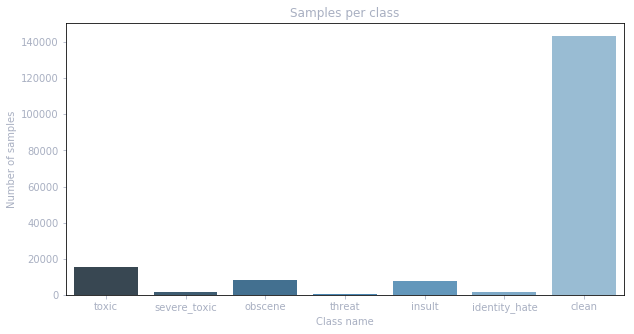

In [10]:
# extended by 'clean' column
summed_labels_extended_train = train_extended.iloc[:,2:].sum()

plt.figure(figsize=(10,5))
plt.title("Samples per class")
plt.ylabel("Number of samples")
plt.xlabel("Class name")
ax = sns.barplot(summed_labels_extended_train.index, summed_labels_extended_train.values, palette="Blues_d")
plt.show()

In [11]:
imbalance_ratios_per_class = {}
for label in range(len(summed_labels_extended_train) - 1):
    ratio_label = n_clean_samples / summed_labels_extended_train.get(label)
    imbalance_ratios_per_class[summed_labels_extended_train.index[label]] = round(ratio_label)

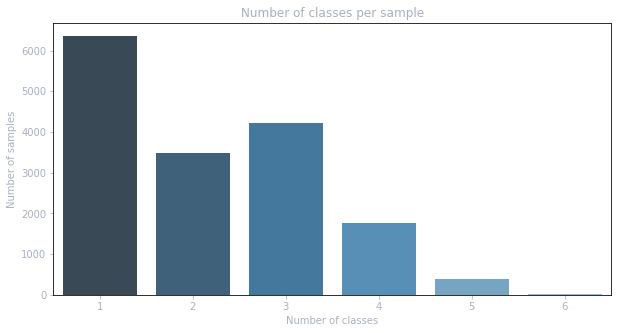

1    6360
3    4209
2    3480
4    1760
5     385
6      31
dtype: int64


In [12]:
# without '0 classes' (clean comments)
multiple_classes_occurance = comments_labels_sums.value_counts().iloc[1:]

plt.figure(figsize=(10,5))
plt.title("Number of classes per sample")
plt.ylabel("Number of samples")
plt.xlabel("Number of classes")
ax = sns.barplot(multiple_classes_occurance.index, multiple_classes_occurance.values, palette="Blues_d")
plt.show()
print(multiple_classes_occurance)

In [13]:
print("Single-classed toxic comments:", '{0:.2f}'.format(multiple_classes_occurance.get(1) / n_toxic_samples * 100), '%')
print("Multiple-classed toxic comments:", '{0:.2f}'.format(multiple_classes_occurance[1:].sum() / n_toxic_samples * 100), '%')

Single-classed toxic comments: 39.20 %
Multiple-classed toxic comments: 60.80 %


###### <font color="LIGHTSALMON">Most of toxic comments has more than one toxic class</font>

#### Example samples

In [14]:
def get_random_sample(comments_group):
    min_samples_in_class = comments_labels_train.sum().min() - 1
    return comments_group.iloc[randint(0, min_samples_in_class), 1]

In [15]:
toxic_samples = train_extended[train_extended.toxic == 1]
severe_toxic_samples = train_extended[train_extended.severe_toxic == 1]
obscene_samples = train_extended[train_extended.obscene == 1]
threat_samples = train_extended[train_extended.threat == 1]
insult_samples = train_extended[train_extended.insult == 1]
identity_hate_samples = train_extended[train_extended.identity_hate == 1]
clean_samples = train_extended[train_extended.clean == 1]

print("Toxic:\n\n>", get_random_sample(toxic_samples))
print("\n --- \n\nSevere toxic:\n\n>", get_random_sample(severe_toxic_samples))
print("\n --- \n\nObscene:\n\n>", get_random_sample(obscene_samples))
print("\n --- \n\nThreat:\n\n>", get_random_sample(threat_samples))
print("\n --- \n\nInsult:\n\n>", get_random_sample(insult_samples))
print("\n --- \n\nIdentity hate:\n\n>", get_random_sample(identity_hate_samples))
print("\n --- \n\nClean:\n\n>", get_random_sample(clean_samples))

Toxic:

> Al Arbour  

Hey Fucktard. Al Arbour died on Friday. Try having someone read an obituary to you

 --- 

Severe toxic:

> your a bitch  

hey bitch i own  this shit bitch and u suck dick. if u want the chaos to stop meet me at 711 and ill fuck u up any time u want it bitch

 --- 

Obscene:

> I shall look forward to the day I hear of your death, and I intend to continue terrorizing you and make your life a living hell you nasty little stupid Mexican faggot.

 --- 

Threat:

> if i find you i will hang you

 --- 

Insult:

> "

where are my insults? heres an insult for you = you're a fucking blind dipshit. you need to stop being a sensitive cunt. hows that for an insult?  (Talk)  "

 --- 

Identity hate:

> MAYBE ITS BECAUSE YOU ARE A GAY

 --- 

Clean:

> Hi 

Hi, good day.

My deepest apologies that I had made the change.
I had made the change it was because I was there. On the day.
I was there on the day when they are all line up the most straightest one straight line,
the m

#### Wordclouds

#### Spam significance 

In [16]:
train_extended['n_unique_words'] = train_extended["comment_text"].apply(lambda x: len(set(str(x).split())))
train_extended['n_words'] = train_extended["comment_text"].apply(lambda x: len(str(x).split()))
train_extended['unique_words_per'] = train_extended['n_unique_words'] * 100 / train_extended['n_words']

###### <font color="LIGHTSALMON">Spam ratio (coefficient) =  unique words in comment / number of words in comment</font>

In [17]:
spam_ratio = 10
spammers = train_extended[train_extended['unique_words_per'] < spam_ratio]
clean_spammers = spammers[spammers['clean'] == True]
toxic_spammers = spammers[spammers['clean'] == False]
n_clean_spammers = clean_spammers.shape[0]
n_toxic_spammers = toxic_spammers.shape[0]
n_spammers = spammers.shape[0]
print('For spam coefficient equal 10%:\n')
print('Clean spammers: ', n_clean_spammers, "(", round(n_clean_spammers * 100 / n_spammers), "% )")
print('Toxic spammers: ', n_toxic_spammers, "(", round(n_toxic_spammers * 100 / n_spammers), "% )")
print('\nThere are', '{0:.2f}'.format(n_toxic_spammers / n_clean_spammers) ,'times more toxic spammers than clean ones!')

For spam coefficient equal 10%:

Clean spammers:  67 ( 19 % )
Toxic spammers:  292 ( 81 % )

There are 4.36 times more toxic spammers than clean ones!


In [18]:
spam_ratio_values = np.arange(0, 41, 1)
n_clean_spammers_values = []
n_toxic_spammers_values = []
for spam_ratio in spam_ratio_values:
    curr_spammers = train_extended[train_extended['unique_words_per'] < spam_ratio]
    curr_clean_spammers = curr_spammers[curr_spammers['clean'] == True]
    curr_toxic_spammers = curr_spammers[curr_spammers['clean'] == False]
    n_clean_spammers_values.append(curr_clean_spammers.shape[0])
    n_toxic_spammers_values.append(curr_toxic_spammers.shape[0])

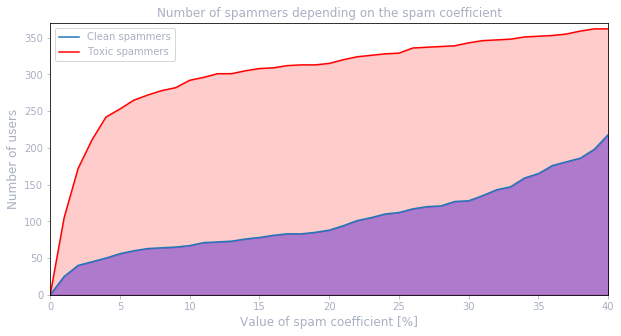

In [19]:
plt.title("Number of spammers depending on the spam coefficient", fontsize=12)

plt.plot(spam_ratio_values, n_clean_spammers_values)
plt.fill_between(spam_ratio_values, n_clean_spammers_values, 0, color='blue', alpha=0.4)  
plt.plot(spam_ratio_values, n_toxic_spammers_values, 'r')
plt.fill_between(spam_ratio_values, n_toxic_spammers_values, 0, color='red', alpha=0.2) 

plt.legend(['Clean spammers', 'Toxic spammers'])
plt.ylabel('Number of users', fontsize=12)
plt.xlabel('Value of spam coefficient [%]', fontsize=12)
plt.xlim(0, 40)
plt.ylim(0, 370)
plt.show()

In [20]:
spam_min_index = min(n_clean_spammers, n_toxic_spammers) - 1
print("Sample clean spam:\n\n>", clean_spammers.iloc[randint(0, spam_min_index)].comment_text)
print("\n --- \n\nSample toxic spam:\n\n>", toxic_spammers.iloc[randint(0, spam_min_index)].comment_text)

Sample clean spam:

> user: user:precious Roy go away and bother someone else, you are not wanted here, stop stalking 
user: user:precious Roy go away and bother someone else, you are not wanted here, stop stalking 
user: user:precious Roy go away and bother someone else, you are not wanted here, stop stalking 
user: user:precious Roy go away and bother someone else, you are not wanted here, stop stalking 
user: user:precious Roy go away and bother someone else, you are not wanted here, stop stalking 
user: user:precious Roy go away and bother someone else, you are not wanted here, stop stalking 
user: user:precious Roy go away and bother someone else, you are not wanted here, stop stalking 
user: user:precious Roy go away and bother someone else, you are not wanted here, stop stalking 
user: user:precious Roy go away and bother someone else, you are not wanted here, stop stalking 
user: user:precious Roy go away and bother someone else, you are not wanted here, stop stalking 
user: us

### Prepare data for model training

#####  Comments tokenizing

In [21]:
classes_names = train.columns.values[2:]
labels_train = train[classes_names].values
comments_train = train["comment_text"]
comments_test = test["comment_text"]

In [22]:
num_words = 25000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(comments_train))
print('Found %d unique words.' % len(tokenizer.word_index))

Found 210337 unique words.


In [23]:
# Check first 20 unique words with the highest occurance from our dictonary
dict(list(tokenizer.word_index.items())[0:20])

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'have': 18,
 'are': 19,
 'your': 20}

In [24]:
tokenized_sequences_train = tokenizer.texts_to_sequences(comments_train)
tokenized_sequences_test = tokenizer.texts_to_sequences(comments_test)

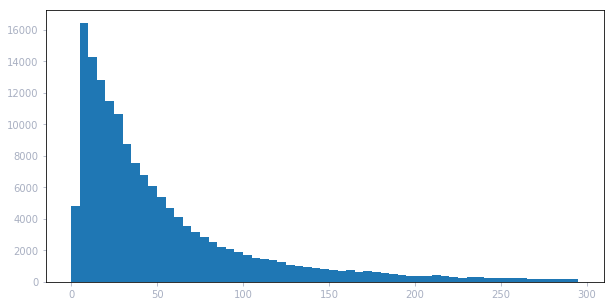

In [25]:
# Analysis of lengths of comments (maxlen param)
n_words_comments = [len(comment) for comment in tokenized_sequences_train]
plt.hist(n_words_comments, bins=np.arange(0,300,5))
plt.show()

##### Vector padding

In [26]:
maxlen = 180
fixed_sequences_train = pad_sequences(tokenized_sequences_train, maxlen=maxlen)
fixed_sequences_test = pad_sequences(tokenized_sequences_test, maxlen=maxlen)

print('Before padding: (', len(tokenized_sequences_train[6]) ,'elements )\n', tokenized_sequences_train[6])
print('\nAfter padding: (', len(fixed_sequences_train[6]) ,'elements )\n', fixed_sequences_train[6])

Before padding: ( 8 elements )
 [1873, 147, 6, 3476, 324, 15, 29, 141]

After padding: ( 180 elements )
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 1873  147    6 3476  3

### Building the model

In [47]:
# Initialize all params used in both solutions of bulding the model
# Commented params are tuned by Grid Search
embedding_output_dim = 64
lstm_units = 100
lstm_recurrent_dropout = 0.2
lstm_return_sequences = True
dropout_rate = 0.2 
relu_dense_units = 50
optimizer = 'adam'

In [48]:
# Params for model training
batch_size = 64
epochs = 2
n_classes = len(classes_names)

In [49]:
# Methods for calculating metrcis
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

##### Tuning params with Grid Search

In [50]:
def create_model(embedding_output_dim = 64, 
                 lstm_units = 100, 
                 lstm_recurrent_dropout = 0.2, 
                 lstm_return_sequences = True, 
                 dropout_rate = 0.2, 
                 relu_dense_units = 50, 
                 optimizer = 'adam'):
    
    model = Sequential()
    model.add(Embedding(input_dim=num_words, output_dim=embedding_output_dim))
    model.add(LSTM(units=lstm_units, 
                   return_sequences=lstm_return_sequences, 
                   recurrent_dropout=lstm_recurrent_dropout))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=relu_dense_units, activation='relu'))
    model.add(Dense(n_classes, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[sensitivity, specificity])
    return model

In [51]:
param_grid = {
    'embedding_output_dim': [8, 32, 128],
    'lstm_units': [20, 100, 500],
    'dropout_rate': [0.2, 0.5, 0.9],
    'optimizer': ['adam', 'adamax', 'nadam'],
    'dense_units': [10, 100, 500],
    'lstm_recurrent_dropout': [0.2, 0.5, 0.9],
    'lstm_return_sequences': [True, False]
}

In [52]:
model = KerasClassifier(build_fn=create_model, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=0.1,
                        verbose=1)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

### Model training

In [ ]:
X_train = fixed_sequences_train
y_train = labels_train

grid_result = grid.fit(X_train, y_train, class_weight=imbalance_ratios_per_class,)

In [44]:
print("Best params: %s (%f)" % (grid_result.best_params_, grid_result.best_score_))

Best params: {'dropout_rate': 0.2} (0.981812)


In [55]:
params = grid_result.cv_results_['params']
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
print('All results:')
for param, mean, std in zip(params, means, stds):
    print('\nSet of params: %r\n Mean: (%f); Standard deviation: %f' % (param, mean, std))

All results:

Set of params: {'dropout_rate': 0.2}
 Mean: (0.981812); Standard deviation: 0.000457

Set of params: {'dropout_rate': 0.4}
 Mean: (0.981774); Standard deviation: 0.000395


In [26]:
name_model_file = 'best-model-gridsearch.json'
name_weights_file = 'best-weights-gridsearch.h5'

def save_model_to_JSON(model):
    model_json = model.to_json()
    with open(f'{MODEL_PATH}{name_model_file}', 'w') as json_file:
        json_file.write(model_json)
    print('Saved model to disk')
        
def save_weights_to_HDF5(model):
    model.save_weights(f'{MODEL_PATH}{name_weights_file}')
    print('Saved weights to disk')

def load_json_wih_weights_to_model(name_model_file, name_weights_file):
    json_file = open(f'{MODEL_PATH}{name_model_file}', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(f'{MODEL_PATH}{name_weights_file}')
    print('Loaded model with weights from disk')
    return loaded_model

In [60]:
# Save model
best_model = grid_result.best_estimator_.model
save_model_to_JSON(best_model)
save_weights_to_HDF5(best_model)

Saved model to disk
Saved weights to disk


In [27]:
# Load model
loaded_model = load_json_wih_weights_to_model(name_model_file, name_weights_file)
loaded_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model with weights from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          1600000   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 100)         66000     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
___________________________________________________

##### Predicting on test dataset

In [68]:
def drop_entries_with_invalid_labels(test, test_labels):
    indexes_invalid_labels = test_labels.index[test_labels['toxic'] == -1].tolist()
    valid_test_labels = test_labels.drop(test_labels.index[indexes_invalid_labels])
    valid_test = np.delete(test, indexes_invalid_labels, axis=0)
    assert (valid_test_labels.shape[0] == len(valid_test))
    return valid_test, valid_test_labels

In [69]:
test_labels_without_ids = test_labels.iloc[:,1:]
X_test, y_test_df = drop_entries_with_invalid_labels(fixed_sequences_test, test_labels_without_ids)

y_pred_float = loaded_model.predict([X_test], batch_size=1024)
y_pred = (y_pred_float > .5)
y_test = y_test_df.values

Confusion matrices:


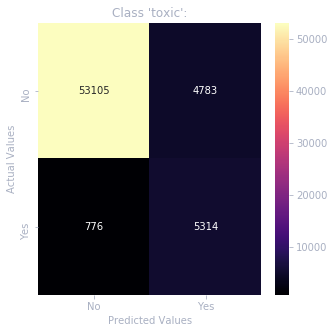

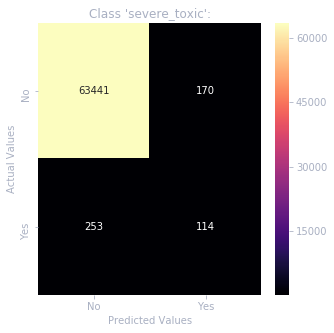

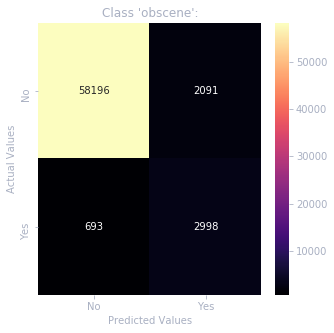

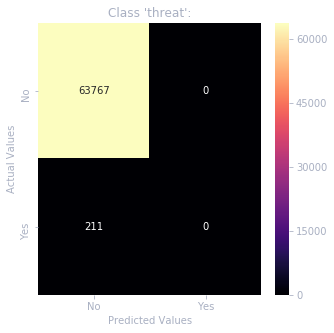

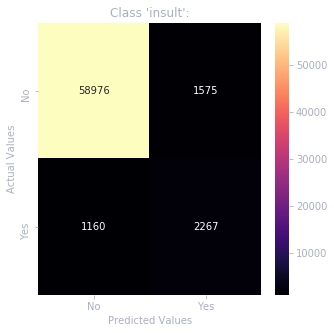

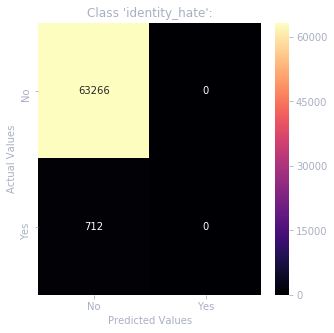

In [70]:
conf_matrices = {}
for label in range(len(classes_names)):
    y_test_label = y_test[:, label]
    y_pred_label = y_pred[:, label]
    conf_matrices[classes_names[label]] = confusion_matrix(y_pred=y_pred_label, y_true=y_test_label)
    
print("Confusion matrices:")
for label, matrix in conf_matrices.items():
    df_cm = pd.DataFrame(matrix, index = [i for i in ['No', 'Yes']], columns = [i for i in ['No', 'Yes']])
    plt.figure(figsize = (5, 5))
    ax = plt.axes()
    sns.heatmap(df_cm, annot=True, cmap='magma', fmt='g')
    ax.set_title("Class '{}':".format(label))
    ax.set_ylabel('Actual Values')    
    ax.set_xlabel('Predicted Values')
    plt.show()

##### Create submission file

##### Manual model testing

In [71]:
def prepare_comment(comment):
    tokenized_comment = tokenizer.texts_to_sequences(comment)
    return pad_sequences(tokenized_comment, maxlen=maxlen)

In [74]:
single_comment = 'Meh!'
single_prediction = loaded_model.predict([prepare_comment([single_comment])], batch_size=1024)
results = pd.DataFrame(single_prediction, columns=[classes_names])

class_with_highest_prob = results.idxmax(axis=1).get(0)[0]
highest_prob = results.max(axis=1).get(0)

happy_face = '\ (•◡•) /'
sad_face = '¯\_(ツ)_/¯'

if (highest_prob > .5):
    print('\nDeteced class: ', class_with_highest_prob, '\nScore: ', highest_prob * 100, ' %\n\n', sad_face)
else:
    print('\nNo toxicity detected!\n\n', happy_face)
print('\nAll results:\n', results)


No toxicity detected!

 \ (•◡•) /

All results:
       toxic severe_toxic   obscene    threat    insult identity_hate
0  0.038827     0.000205  0.007519  0.000876  0.005185      0.002721


##### <font color="#7affa0">TODO:</font>
- <font color="green">✔</font> add plot of spammers classification based on variable spam_ratio
- try to use new features from EDA during model fitting
- execute SearchGrid of model's params
    - try diffrent values of non-model params num_words (Tokenizer), maxlen (padding)
- <font color="green">✔</font> update Tensorflow to GPU version
- try diffrent architectures e.g. Pooling (Max -> Average), Early Stopping and Checkpoints (callbacks), Pretrained Embedding (Glove), LSTM with Bidirectional

##### <font color="#a07aff">Konsultacje:</font>
- Klasyfikacja dwupoziomowa: binarna (clean/toxic data) + wieloetykietowa (tylko toxic data); dwa klasyfikatory
- Dataset jest niezrównoważony (10/90); klasyfikacja niezrównoważona
- Oversampling (sprawdzić)
- <font color="green">✔</font> Sprawdzić macierz pomyłek
- Klasyfikacja hierarchiczna (np. severe toxic zawsze jest toxic)
- <b>Zrobić przegląd literatury</b>